<a href="https://colab.research.google.com/github/jmmzhng-pro/DSCI_631_Project/blob/main/04_Feature_Selection_ML_Pipeline_Optimization%20/JZ_Feature_Aggregation_and_Selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**DSCI 631 Final Project**

- Group member
    - Name: Jonathan Watkins
    - Email: jfw68@drexel.edu
- Group member
    - Name: Jake Jarosik
    - Email: jj3268@drexel.edu
- Group member
    - Name: Jimmy Zhang
    - Email: jz876@drexel.edu


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [5]:
#function to convert to pandas of string of time to date
from dateutil import parser
from datetime import datetime

def transform_to_date(pandas_object, col_name=''):
  if col_name == '':
    pandas_object = pandas_object.apply(parser.parse).apply(datetime.date)
    return pandas_object
  else:
    pandas_object[col_name] = pandas_object['col_name'].apply(parser.parse).apply(datetime.date)
    return pandas_object[col_name]

In [36]:
#define global path vars

interest_rate_dir = '/content/drive/MyDrive/DSCI 631 Assignments and Project/Project/Final Project/Datasets/InterestRate/'
fomc_sentiment_dir = '/content/drive/MyDrive/DSCI 631 Assignments and Project/Project/Final Project/Datasets/FOMC_Data_Analyzed/'
stock_price_dir = '/content/drive/MyDrive/DSCI 631 Assignments and Project/Project/Final Project/Datasets/StockPrice/'
bls_dir = '/content/drive/MyDrive/DSCI 631 Assignments and Project/Project/Final Project/Datasets/BLS/'
sec_dir = '/content/drive/MyDrive/DSCI 631 Assignments and Project/Project/Final Project/Datasets/SEC/'

top_30_tickers = ['AAPL', 'MSFT', 'AMZN', 'NVDA', 'GOOGL', 'META', 'GOOG', 'TSLA', 'BRK.B',
                  'UNH', 'LLY', 'JPM', 'AVGO', 'V', 'XOM', 'JNJ', 'MA', 'PG', 'HD', 'ADBE',
                  'COST', 'ABBV', 'MRK', 'CVX', 'CRM', 'KO', 'PEP', 'WMT', 'BAC', 'ACN']

sec_tags = ['Assets.csv',
            'LiabilitiesAndStockholdersEquity.csv',
            'NetCashProvidedByUsedInFinancingActivities.csv',
            'NetCashProvidedByUsedInInvestingActivities.csv']

bls_features = ['CPI_flattened.csv',
                'ConsumerExpenditureSurvey_flattened.csv',
                'PPI_manufacturing_flattened.csv',
                'PPI_industry_flattened.csv',
                'PPI_commod_flattened.csv',
                'unemployment_flattened.csv']

target_ticker = '^GSPC'

In [17]:
df_target = pd.read_csv(stock_price_dir + target_ticker + '.csv')
df_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4013 entries, 0 to 4012
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          4013 non-null   object 
 1   Open          4013 non-null   float64
 2   High          4013 non-null   float64
 3   Low           4013 non-null   float64
 4   Close         4013 non-null   float64
 5   Volume        4013 non-null   int64  
 6   Dividends     4013 non-null   float64
 7   Stock Splits  4013 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 250.9+ KB


In [18]:
df_target['Stock Splits'].value_counts()

0.0    4013
Name: Stock Splits, dtype: int64

In [19]:
df_target['Dividends'].value_counts()

0.0    4013
Name: Dividends, dtype: int64

In [20]:
df_target['Date'] = transform_to_date(df_target['Date'])
df_target = df_target[['Date', 'Close']]

#let rename target variable to y and the main time variable to ds
df_target = df_target.rename(columns={'Date': 'ds',
                                      'Close': 'y'})

In [ ]:
#Rationale for Stock Price Feature Selection.
#We are going to use the Daily Open Price of the top 30 stocks in the S&P 500 to target the Daily Close Price of the S&P 500 Index Fund.
#We will also use Dividend and Stock Split information as well, as by SEC regulations - these events must be announced ahead of time
#We will drop Close, High, Low, and Volume as these are dictated by the price movement action of on that day - and would be considered a form of Data Leakage

In [34]:
#initialize the first merged df - top 30 Companies in the S&P 500 Daily Open Stock Price
df_merged_1 = df_target.copy()

for company_ticker in top_30_tickers:
  try:
    #load data
    company_ticker_df = pd.read_csv(stock_price_dir + company_ticker + '.csv')

    #rename cols
    company_ticker_df = company_ticker_df.add_prefix(f'{company_ticker}_')

    #convert to date
    company_ticker_df[f'{company_ticker}_Date'] = transform_to_date(company_ticker_df[f'{company_ticker}_Date'])

    #merge df's
    df_merged_1 = pd.merge(df_merged_1, left_on='ds',
                          right=company_ticker_df[[f'{company_ticker}_Date', f'{company_ticker}_Open']], right_on=f'{company_ticker}_Date',
                          how='left')

    #drop secondary date column
    df_merged_1.drop(columns=[f'{company_ticker}_Date'], inplace=True)
  except Exception as e:
    print(f'Error: Data did not load properly for {company_ticker} - {e}')

df_merged_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4013 entries, 0 to 4012
Data columns (total 32 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ds          4013 non-null   object 
 1   y           4013 non-null   float64
 2   AAPL_Open   4013 non-null   float64
 3   MSFT_Open   4013 non-null   float64
 4   AMZN_Open   4013 non-null   float64
 5   NVDA_Open   4013 non-null   float64
 6   GOOGL_Open  4013 non-null   float64
 7   META_Open   2909 non-null   float64
 8   GOOG_Open   4013 non-null   float64
 9   TSLA_Open   3386 non-null   float64
 10  BRK.B_Open  0 non-null      object 
 11  UNH_Open    4013 non-null   float64
 12  LLY_Open    4013 non-null   float64
 13  JPM_Open    4013 non-null   float64
 14  AVGO_Open   3611 non-null   float64
 15  V_Open      3960 non-null   float64
 16  XOM_Open    4013 non-null   float64
 17  JNJ_Open    4013 non-null   float64
 18  MA_Open     4013 non-null   float64
 19  PG_Open     4013 non-null  

In [ ]:
#Rationale for SEC Data - As we saw in the SEC EDA section, Quarterly Earning Reports vary widely.
#Thus, we will only use the most prevalent earnings report tags from the top 30 companies

In [49]:
#initialize the second merged df - top 30 Companies in S&P 500 - SEC Data
df_merged_2 = df_merged_1.copy()

for company_ticker in top_30_tickers:
  for sec_tag in sec_tags:
    try:
      #load data
      ticker_sec_tag_df = pd.read_csv(sec_dir + company_ticker + '/' + sec_tag)

      #rename cols
      tag_name = sec_tag[:-4]
      ticker_sec_tag_df = ticker_sec_tag_df.add_prefix(f'{company_ticker}_{tag_name}_')

      #convert to date
      ticker_sec_tag_df[f'{company_ticker}_{tag_name}_end'] = transform_to_date(ticker_sec_tag_df[f'{company_ticker}_{tag_name}_end'])

      #subset SEC tag data to quarterly earning report 10-K
      ticker_sec_tag_df_sub = ticker_sec_tag_df[(ticker_sec_tag_df[f'{company_ticker}_{tag_name}_form'] == '10-K') & (ticker_sec_tag_df[f'{company_ticker}_{tag_name}_frame'].notna())]

      #merge df's
      df_merged_2 = pd.merge(df_merged_2, left_on='ds',
                            right=ticker_sec_tag_df_sub[[f'{company_ticker}_{tag_name}_end', f'{company_ticker}_{tag_name}_val']], right_on=f'{company_ticker}_{tag_name}_end',
                            how='left')

      #drop secondary date column
      df_merged_2.drop(columns=[f'{company_ticker}_{tag_name}_end'], inplace=True)
    except Exception as e:
      print(f'Error: {e}')


df_merged_2.columns

Index(['ds', 'y', 'AAPL_Open', 'MSFT_Open', 'AMZN_Open', 'NVDA_Open',
       'GOOGL_Open', 'META_Open', 'GOOG_Open', 'TSLA_Open',
       ...
       'WMT_NetCashProvidedByUsedInFinancingActivities_val',
       'WMT_NetCashProvidedByUsedInInvestingActivities_val', 'BAC_Assets_val',
       'BAC_LiabilitiesAndStockholdersEquity_val',
       'BAC_NetCashProvidedByUsedInFinancingActivities_val',
       'BAC_NetCashProvidedByUsedInInvestingActivities_val', 'ACN_Assets_val',
       'ACN_LiabilitiesAndStockholdersEquity_val',
       'ACN_NetCashProvidedByUsedInFinancingActivities_val',
       'ACN_NetCashProvidedByUsedInInvestingActivities_val'],
      dtype='object', length=152)

In [57]:
#initialize the third merged df - BLS Data
df_merged_3 = df_merged_2.copy()

for bls_feature in bls_features:
    try:
      #load data
      bls_df = pd.read_csv(bls_dir + '/' + bls_feature)

      #rename cols
      feature_name = bls_feature.split('flattened')[0]
      bls_df = bls_df.add_prefix(f'{feature_name}')

      #convert to date
      bls_df[f'{feature_name}DateTime'] = transform_to_date(bls_df[f'{feature_name}DateTime'])

      #merge df's
      if f'{feature_name}MonthOverMonth' in bls_df.columns:
        df_merged_3 = pd.merge(df_merged_3, left_on='ds',
                              right=bls_df[[f'{feature_name}DateTime', f'{feature_name}YearOverYear', f'{feature_name}MonthOverMonth']], right_on=f'{feature_name}DateTime',
                              how='left')
      else:
        df_merged_3 = pd.merge(df_merged_3, left_on='ds',
                              right=bls_df[[f'{feature_name}DateTime', f'{feature_name}YearOverYear']], right_on=f'{feature_name}DateTime',
                              how='left')

      #drop secondary date column
      df_merged_3.drop(columns=[f'{feature_name}DateTime'], inplace=True)

    except Exception as e:
      print(f'Error: {e}')


df_merged_3.columns

Index(['ds', 'y', 'AAPL_Open', 'MSFT_Open', 'AMZN_Open', 'NVDA_Open',
       'GOOGL_Open', 'META_Open', 'GOOG_Open', 'TSLA_Open',
       ...
       'CPI_MonthOverMonth', 'ConsumerExpenditureSurvey_YearOverYear',
       'PPI_manufacturing_YearOverYear', 'PPI_manufacturing_MonthOverMonth',
       'PPI_industry_YearOverYear', 'PPI_industry_MonthOverMonth',
       'PPI_commod_YearOverYear', 'PPI_commod_MonthOverMonth',
       'unemployment_YearOverYear', 'unemployment_MonthOverMonth'],
      dtype='object', length=163)

In [62]:
#initialize the fourth merged df - Interest Rate and FOMC Sentiment
df_merged_4 = df_merged_3.copy()

#load data
interest_rates_df = pd.read_csv(interest_rate_dir + 'InterestRateSecurities.csv')
fomc_sentiment_df = pd.read_csv(fomc_sentiment_dir + 'fomc_sentiment_analysis.csv')


#convert date string to date
interest_rates_df['record_date'] = transform_to_date(interest_rates_df['record_date'])
fomc_sentiment_df['date'] = transform_to_date(fomc_sentiment_df['date'])

#merge into one dataframe
df_merged_4 = pd.merge(df_merged_4, left_on='ds',
                      right=interest_rates_df, right_on='record_date', how='left')
df_merged_4 = pd.merge(df_merged_4, left_on='ds',
                      right=fomc_sentiment_df[['date','sentiment']], right_on='date', how='left')

#drop secondary date column
df_merged_4.drop(columns=['record_date', 'date'], inplace=True)

#show cols
df_merged_4.columns

Index(['ds', 'y', 'AAPL_Open', 'MSFT_Open', 'AMZN_Open', 'NVDA_Open',
       'GOOGL_Open', 'META_Open', 'GOOG_Open', 'TSLA_Open',
       ...
       'Total Marketable', 'Total Non-marketable', 'Treasury Bills',
       'Treasury Bonds', 'Treasury Floating Rate Notes (FRN)',
       'Treasury Inflation-Protected Securities (TIPS)', 'Treasury Notes',
       'United States Savings Inflation Securities',
       'United States Savings Securities', 'sentiment'],
      dtype='object', length=183)

In [63]:
#save final df
final_df = df_merged_4.copy()
final_df.to_csv('/content/drive/MyDrive/DSCI 631 Assignments and Project/Project/Final Project/Datasets/CompliedDataset.csv')

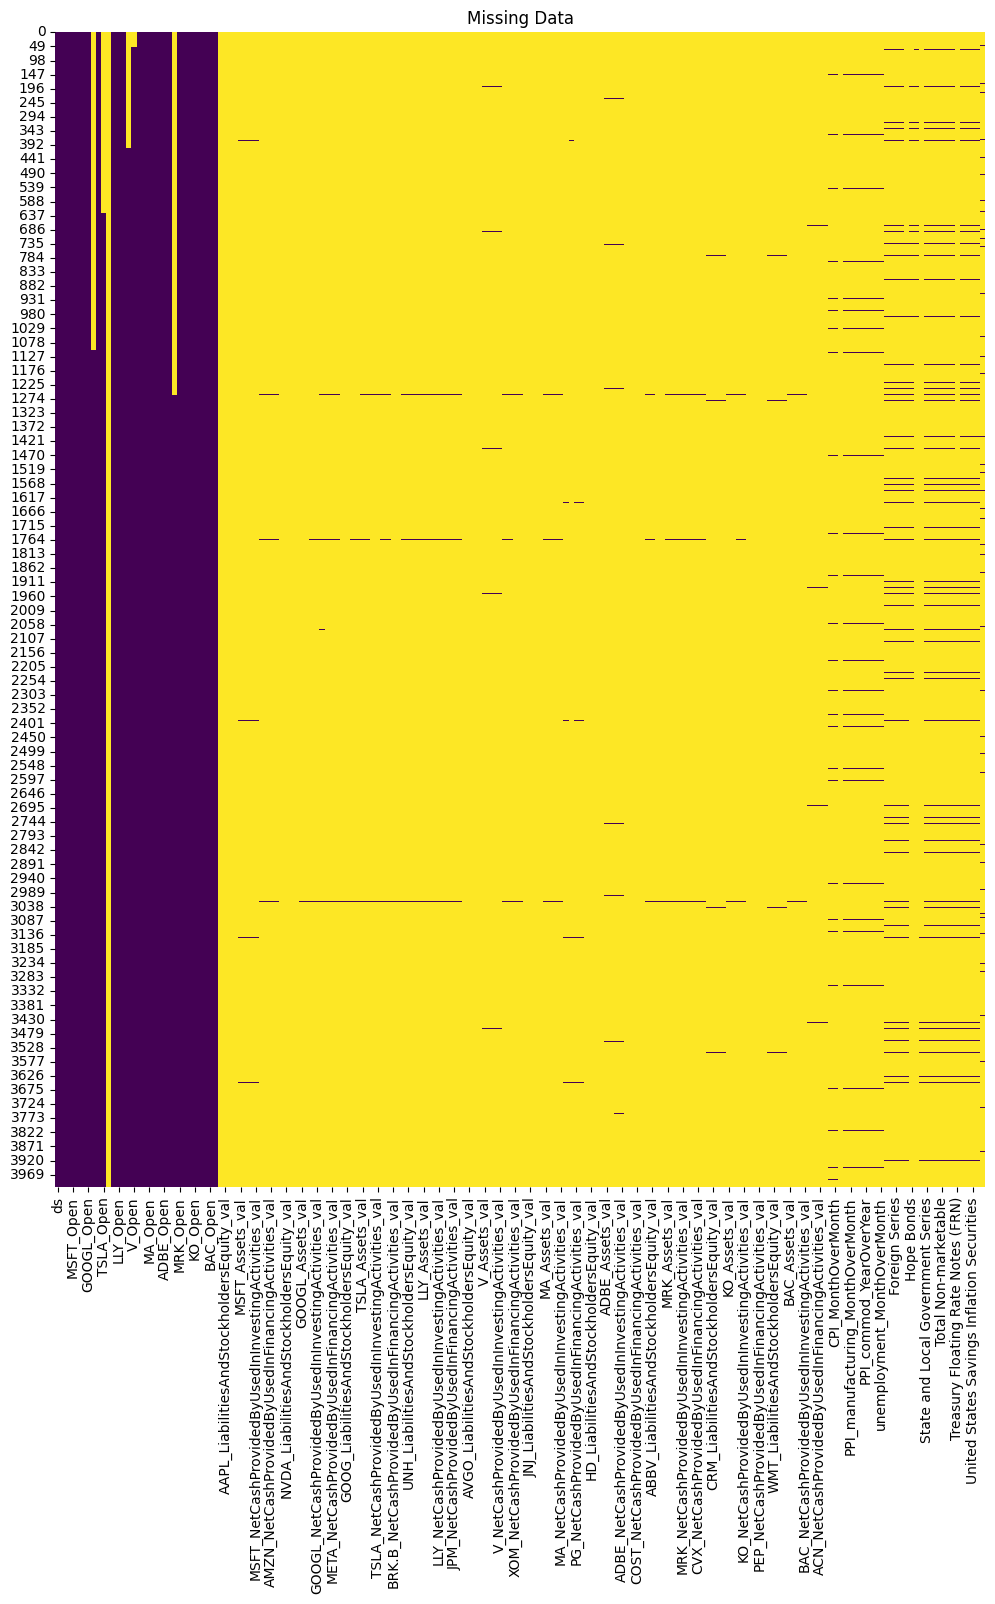

In [68]:
import seaborn as sns

# Create a heatmap of missing data
plt.figure(figsize=(12, 15))
sns.heatmap(final_df.isnull(), cmap='viridis', cbar=False)
plt.title('Missing Data')
plt.show()

In [64]:
#impute by last value carried forward
final_df_imputed = final_df.fillna(method='ffill')

#save
final_df_imputed.to_csv('/content/drive/MyDrive/DSCI 631 Assignments and Project/Project/Final Project/Datasets/CompliedDataset_LVCF_Imputation.csv')

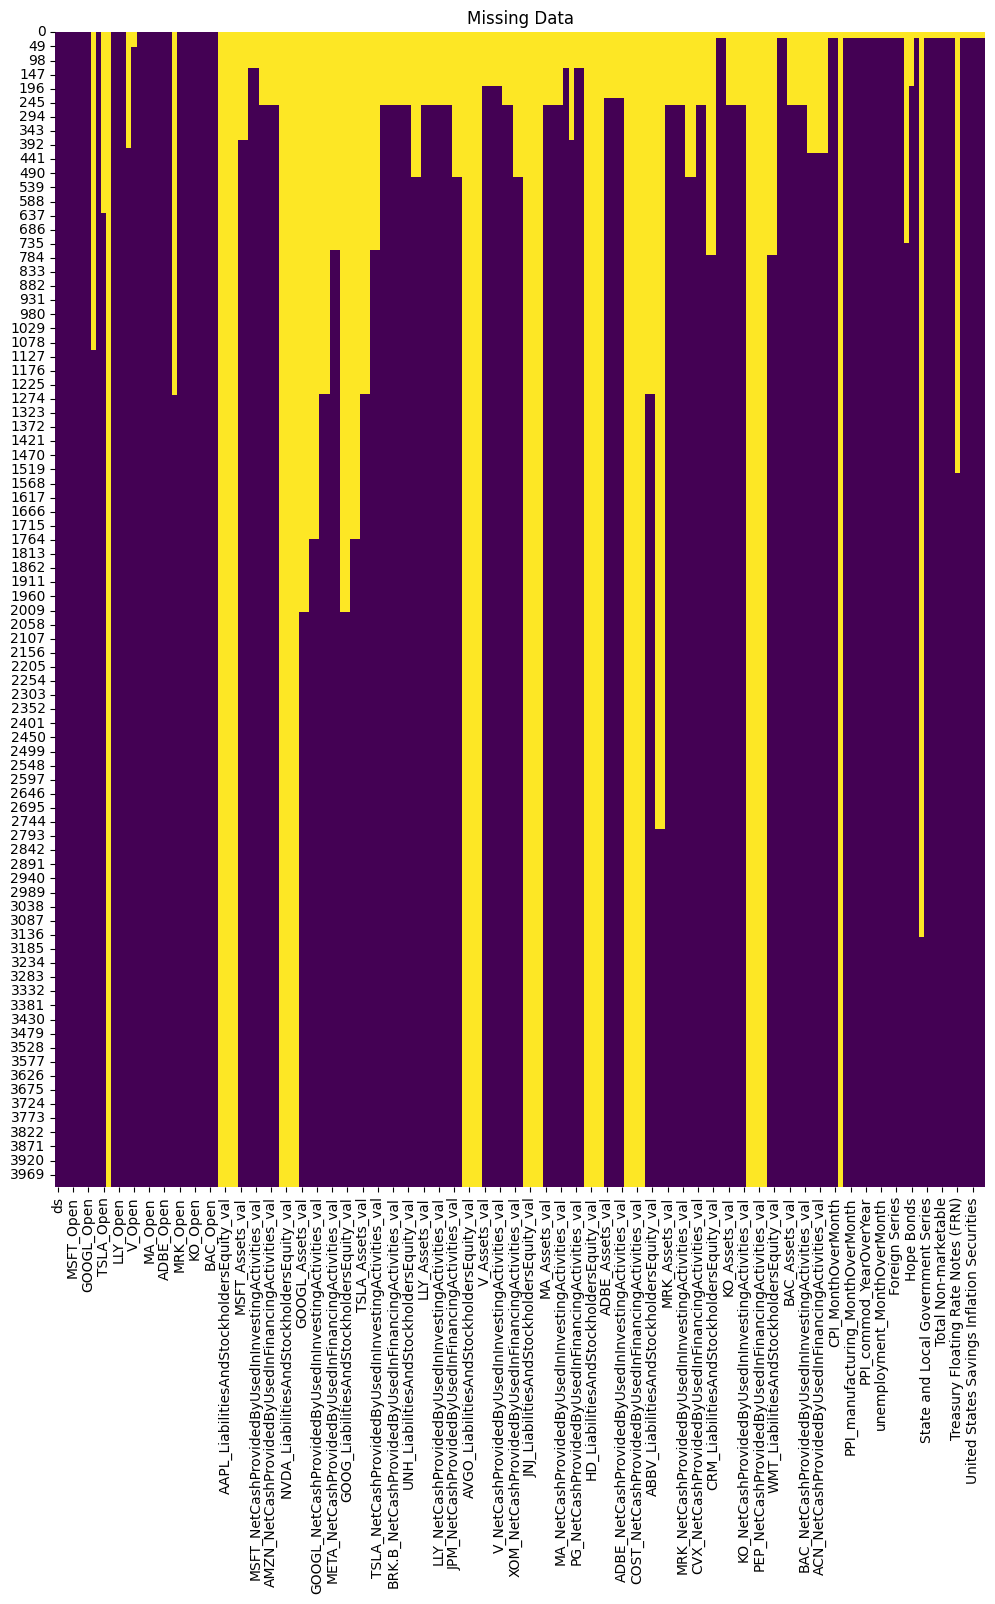

In [69]:
# Create a heatmap of missing data after imputation
plt.figure(figsize=(12, 15))
sns.heatmap(final_df_imputed.isnull(), cmap='viridis', cbar=False)
plt.title('Missing Data')
plt.show()

In [71]:
#drop any columns that are still more that 25% null
final_df_imputed_prepared = final_df_imputed.copy()

for col in final_df_imputed_prepared.columns:
  if (final_df_imputed_prepared[col].isnull().sum() / final_df_imputed_prepared[col].shape[0]) > 0.25:
      final_df_imputed_prepared.drop(columns=[col], inplace=True)

#save
final_df_imputed_prepared.to_csv('/content/drive/MyDrive/DSCI 631 Assignments and Project/Project/Final Project/Datasets/CompliedDataset_LVCF_Imputation_Prepared.csv')

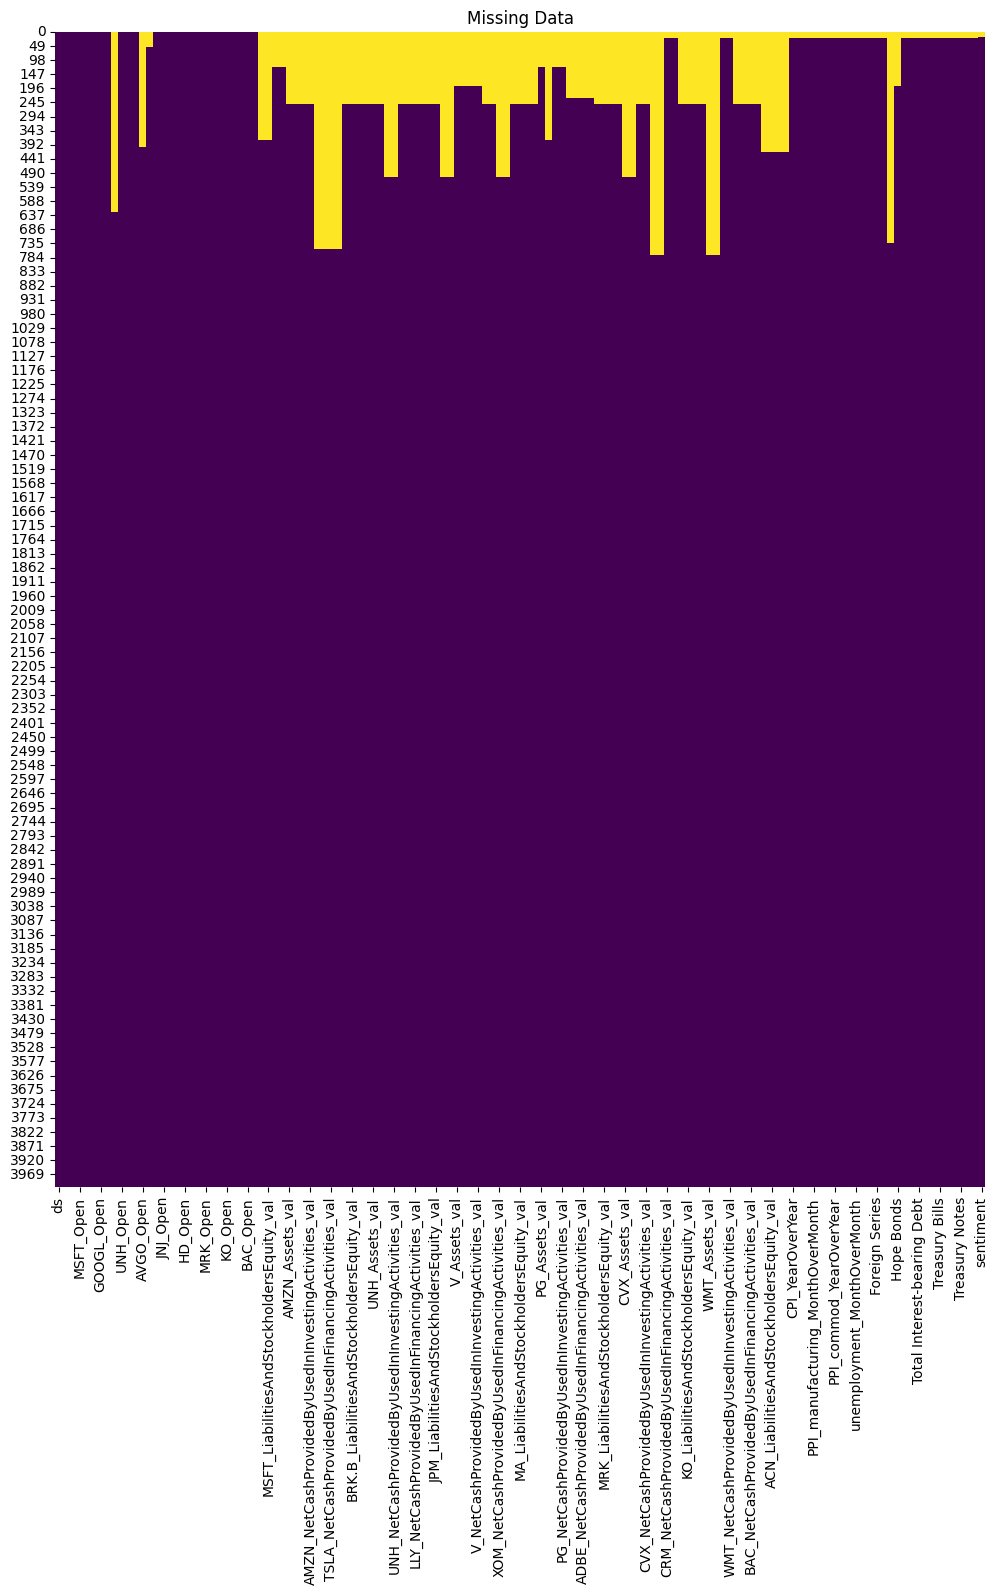

In [73]:
# Create a heatmap of missing data after imputation and preparing
plt.figure(figsize=(12, 15))
sns.heatmap(final_df_imputed_prepared.isnull(), cmap='viridis', cbar=False)
plt.title('Missing Data')
plt.show()